<h3>The Harmonic Oscillator</h3>
This notebook sets up some basic classical and thermodyanmic simulations with the harmonic oscillator potential.

The Harmonic Oscillator is one of the most important systems in both quantum and classical physics. Here, we'll use it to explore Buckyball's dynamics simulatinos.

In [13]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *

import moldesign as mdt
from moldesign import units as u

First, let's set up the potential. We're using a simple 1-d harmonic oscillator that will be applied to the x coordinate of the first atom in the system. The potential has the form $$V_{HO}(x) = \frac{1}{2} k x^2,$$
where $k$ is the "SPRING_CONSTANT" variable.

As with more realistic chemical systems, we'll need to specify the units of all physical quantities.

In [4]:
SPRING_CONSTANT = 1.0*u.kcalpermol/(u.angstrom**2)
model = mdt.models.HarmonicOscillator(k=SPRING_CONSTANT)

Next, we'll set up a simple 1-atom system to play with. The atom we use isn't important - we're just going to subject it to the external harmonic potential.

In [6]:
atom = mdt.Atom(atnum=8, mass=1.0*u.amu)
mol = mdt.Molecule([atom])
mol.set_energy_model(model)

Let's take a look at this model's potential energy and forces. Because this is a 1-dimensional model, we can just scan along the x-coordinate of the first atom.

In [8]:
scan = mdt.trajectory.Trajectory(mol)
for x in u.angstrom*np.arange(-2.0,2.0,0.05):
    atom.x = x
    mol.calculate()
    scan.new_frame()

INFO: Copying atoms into new molecule


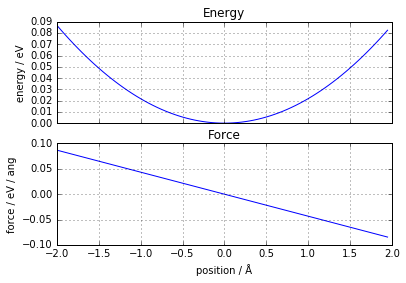

In [14]:
xs = scan.positions[:,0]
subplot(211).set_title('Energy')
plot(xs,scan.potential_energy,label='potential')
ylabel('energy / {}'.format(scan.potential_energy.units))
tick_params(axis='x',labelbottom='off'); grid()
subplot(212).set_title('Force')
plot(xs,scan.forces[:,0],label=u'force')
grid()
xlabel(u'position / Å'); ylabel('force / {}'.format(scan.forces.units))

## Modeling
Next, let's actually do something with the model. We'll move the atom far away from the equilibrium position at $x=0$, and then run a basic minimization to find the equilibrium again.

In [15]:
atom.x = 4.0 * u.angstrom
minimization = mol.minimize(frame_interval=1)

INFO: Copying atoms into new molecule
Starting geometry optimization: scipy.fmin_bfgs with analytical gradients
Step 1/20, ΔE=-3.093e+00 kcalpermol, RMS ∇E=1.525e-03, max ∇E=2.642e-03hartree / bohr
Step 2/20, ΔE=-7.352e+00 kcalpermol, RMS ∇E=5.542e-04, max ∇E=9.599e-04hartree / bohr
Step 3/20, ΔE=-8.000e+00 kcalpermol, RMS ∇E=0.000e+00, max ∇E=0.000e+00hartree / bohr
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5
Reduced energy from 0.346912825766 eV to 0.0 eV


That likely went very quickly - most minimization techniques will perform extremely well with harmonic potentials. Let's take a look at what happened during the minimization:

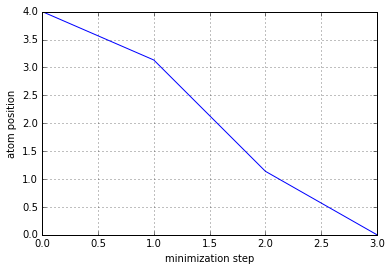

In [18]:
plot(minimization.minimization_step, minimization.positions[:,0])
grid(); xlabel('minimization step'); ylabel('atom position')

viewer = minimization.draw3d()
viewer.vdw()
viewer

## Dynamics
We can also model the atom's motion under this potential.  We'll set up a timestep based "integrator" that solves the Newton's equations of motion to generate a trajectory.

In [20]:
integrator = mdt.integrators.VelocityVerlet(timestep=0.5*u.fs, frame_interval=30)
mol.set_integrator(integrator)

Next, let's specify the system's initial state - what are the starting positions and velocities?

In [21]:
mol.positions[0] = 1.0*u.angstrom
mol.time = 0.0*u.fs
mol.integrator.time = 0.0*u.fs
mol.momenta = 0.0 * u.default.momentum

In [22]:
trajectory = mol.run(1.0*u.ps)

INFO: Copying atoms into new molecule


In [26]:
lone = [atom for atom in mol.atoms if atom.num_bonds == 0]
lone

[<Atom O (elem O), index 0 in molecule Molecule: O1>]

Running the dynamics should take a few seconds. When it's done, let's start by animating the results:

In [23]:
trajectory.draw3d()

Next, let's do some deeper analysis - generate some plots to visualize the trajectory. By now, it should be clear why we call this an "oscillator".

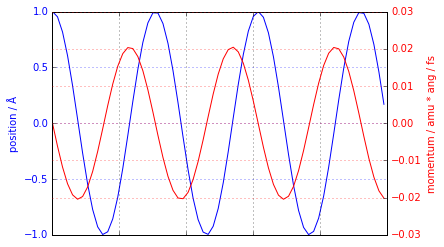

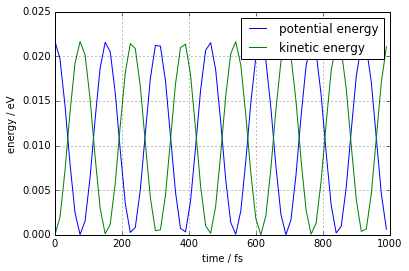

In [29]:
l1 = plot(trajectory.time,trajectory.positions[:,0], label='position')
grid(axis='x', color='black'); grid(color='blue',axis='y')
tick_params(axis='x',labelbottom='off');
ylabel(u'position / Å', color='blue'); yticks(color='blue')
ax2=gca().twinx()
l2 = ax2.plot(trajectory.time,trajectory.momenta[:,0], color='red', label='momentum')
ax2.patch.set_alpha(0.0)
grid(color='red',axis='y'); xlabel('time / fs')
ylabel(u'momentum / {}'.format(u.default.momentum), color='red'); yticks(color='red')
tick_params(axis='x',labelbottom='off')

figure()
pe = trajectory.potential_energy
ke = trajectory.kinetic_energy
plot(trajectory.time, pe,label='potential energy')
plot(trajectory.time, ke,label='kinetic energy')
legend()
grid();xlabel('time / {}'.format(trajectory.time.units));ylabel('energy / {}'.format(pe.units))